In [1]:
import numpy as np
from coppeliasim_zmqremoteapi_client import RemoteAPIClient
import time
import cv2
from cameraCoppelia import CameraCoppelia, world_to_pixel_coordinates, pixel_to_world_coordinates
import matplotlib.pyplot as plt

In [2]:
client = RemoteAPIClient()
client.setStepping(True)

0

In [3]:
sim = client.getObject('sim')
# 2) Handles
robot_handle  = sim.getObject('/PioneerP3DX')
robot_gps_handle = sim.getObject('/PioneerP3DX/GPS')
goal_gps_handle = sim.getObject('/goal/gps')

camera = CameraCoppelia(sim, '/SkyCamera')

In [4]:
K,W,H = camera.getIntrinsics()
R_wc, t_wc = camera.getExtrinsics()
print('Intrinsics:', K)
print('Extrinsics:', R_wc, t_wc)

Intrinsics: [[1.03733035e+03 0.00000000e+00 5.40000000e+02]
 [0.00000000e+00 1.03733035e+03 5.40000000e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
Extrinsics: [[-1.00000000e+00 -2.06623947e-13  9.41833417e-14]
 [-2.06623947e-13  1.00000000e+00 -2.06179858e-13]
 [-9.41833417e-14 -2.06179858e-13 -1.00000000e+00]] [[-4.70916708e-13]
 [ 1.03089929e-12]
 [ 5.00000000e+00]]


In [5]:
# Obtaining Robot 3D World Position
robot_pos = sim.getObjectPosition(robot_gps_handle, -1)
print('Robot Position:', robot_pos)

Robot Position: [-1.7250000000000023, -1.7000000000000008, 0.13878999999999997]


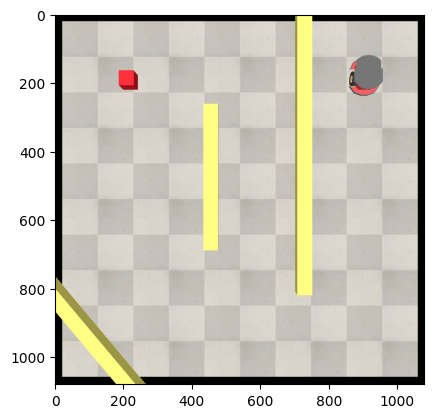

In [6]:
sim.startSimulation()
client.step()
time.sleep(1)
frame, resx, resy = camera.getFrame()
plt.imshow(frame)
sim.stopSimulation()
time.sleep(1)

In [7]:
def depth_on_floor(camera, u, v):
    """
    Compute the camera‐frame depth Z_c of the ray through pixel (u,v)
    that hits the world‐floor Z_w=0.
    """
    # 1) Get intrinsics & extrinsics
    K, W, H      = camera.getIntrinsics()
    R_wc, t_wc   = camera.getExtrinsics()   # world→camera
    R_c2w        = R_wc.T                   # camera→world
    C_w          = -R_c2w @ t_wc            # camera center in world coords (3×1)

    # 2) Ray direction in camera frame
    K_inv        = np.linalg.inv(K)
    ray_cam      = (K_inv @ np.array([u, v, 1.0]).reshape(3,1)).flatten()  # 3-vector

    # 3) Express ray in world coords:
    #    X_w(s) = C_w + s*(R_c2w @ ray_cam)
    ray_w        = (R_c2w @ ray_cam.reshape(3,1)).flatten()  # 3-vector direction
    Cz           = C_w[2,0]                                  # camera’s world-Z
    dz           = ray_w[2]                                  # direction’s world-Z

    if abs(dz) < 1e-6:
        return None  # parallel to floor, no intersection

    # solve C_w.z + s*dz = 0  →  s = -Cw_z / dz
    s = -Cz / dz

    # now depth in camera frame is s * (ray_cam’s Z component)
    depth = s * ray_cam[2]

    return float(depth)


Robot Position: [-1.724949346019562, -1.7002495143032577, 0.13870435724785776]
Robot Position in Image: 908.0793018687941 177.19128583620406
Estimated Robot Position [-1.72494935 -1.70024951  0.13870436]
Robot Position: [-1.724953310902639, -1.700358150398563, 0.13870286849514132]
Robot Position in Image: 908.0800351945685 177.16821557674098
Estimated Robot Position [-1.72495331 -1.70035815  0.13870287]


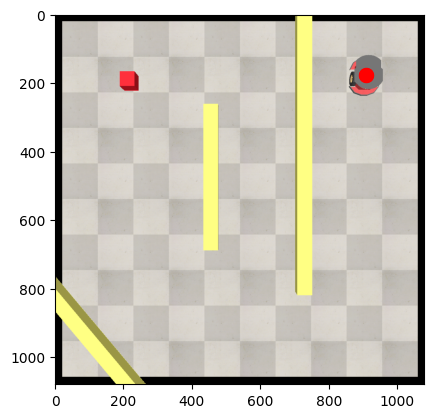

In [8]:
sim.startSimulation()
for _ in range(2):
    client.step()
    time.sleep(0.5)
    client.step()
    cv2_frame, resx, resy = camera.getFrame()
    robot_pos = sim.getObjectPosition(robot_gps_handle, -1)
    print('Robot Position:', robot_pos)
    u,v = world_to_pixel_coordinates(camera, robot_pos[0], robot_pos[1], robot_pos[2])
    print('Robot Position in Image:', u, v)
    # Distance from camera to robot
    # recompute p_c (or reuse it if you stored it) to get Z_c
    p_w = np.array(robot_pos).reshape(3,1)
    p_c = R_wc @ p_w + t_wc
    depth = p_c[2,0]    # <-- the *true* Z_c in camera frame

    print("Estimated Robot Position", pixel_to_world_coordinates(camera, (u,v), depth))

    plt.scatter(u, v, color='red', s=100, label='Robot Position in Image')
    plt.imshow(cv2_frame)
sim.stopSimulation()

In [9]:
def segment_yellow_borders(img_rgb):
    # 1) Convert to HSV
    hsv = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2HSV)

    # 2) Define yellow range (tune these!)
    lower = np.array([20, 100, 100])
    upper = np.array([40, 255, 255])

    # 3) Threshold
    mask = cv2.inRange(hsv, lower, upper)

    # 4) (Optional) Morphological closing to fill gaps
    kernel = np.ones((5,5), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

    # 5) (Optional) Erosion to remove noise
    mask = cv2.erode(mask, kernel, iterations=1)

    # Inverting Colors
    #mask = cv2.bitwise_not(mask)

    return mask


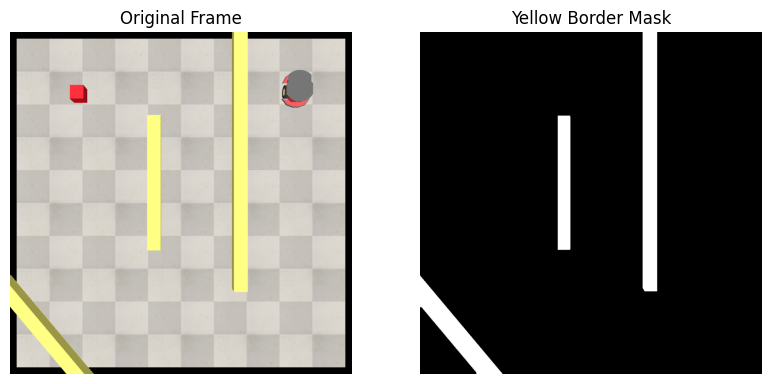

In [10]:
sim.startSimulation()
for _ in range(1):
    client.step()
    time.sleep(0.5)
    client.step()

    # 1. Grab image & segment
    frame, _, _ = camera.getFrame()
    mask = segment_yellow_borders(frame)

    # 4. Plot original frame, mask, and frame with lines
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(frame)
    plt.title('Original Frame')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(mask, cmap='gray')
    plt.title('Yellow Border Mask')
    plt.axis('off')

    plt.show()
sim.stopSimulation()


# DOING A Start

In [11]:
import heapq

def astar(grid, start, goal):
    H, W = grid.shape
    def heuristic(a, b):
        return np.hypot(b[0] - a[0], b[1] - a[1])

    open_set = []
    heapq.heappush(open_set, (0 + heuristic(start, goal), 0, start))
    came_from = {}
    g_score = {start: 0}

    while open_set:
        _, cost, current = heapq.heappop(open_set)
        if current == goal:
            path = [current]
            while current in came_from:
                current = came_from[current]
                path.append(current)
            return path[::-1]

        for dx, dy in [(-1,0), (1,0), (0,-1), (0,1), (-1,-1), (-1,1), (1,-1), (1,1)]:
            neighbor = (current[0] + dx, current[1] + dy)
            if 0 <= neighbor[0] < H and 0 <= neighbor[1] < W and grid[neighbor] != 0:
                tentative_g = g_score[current] + heuristic(current, neighbor)
                if neighbor not in g_score or tentative_g < g_score[neighbor]:
                    g_score[neighbor] = tentative_g
                    f = tentative_g + heuristic(neighbor, goal)
                    heapq.heappush(open_set, (f, tentative_g, neighbor))
                    came_from[neighbor] = current
    return None  # No path found


Grid Shape: (1080, 1080)
Amount of Free Cells: 1090815
Amount of Occupied Cells: 75585


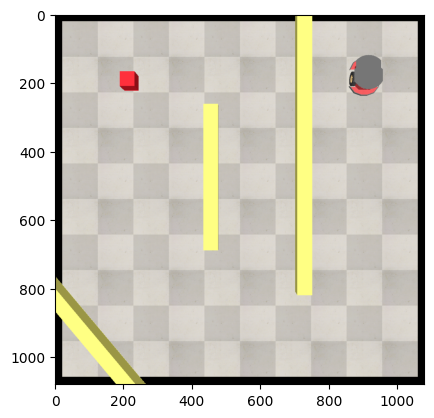

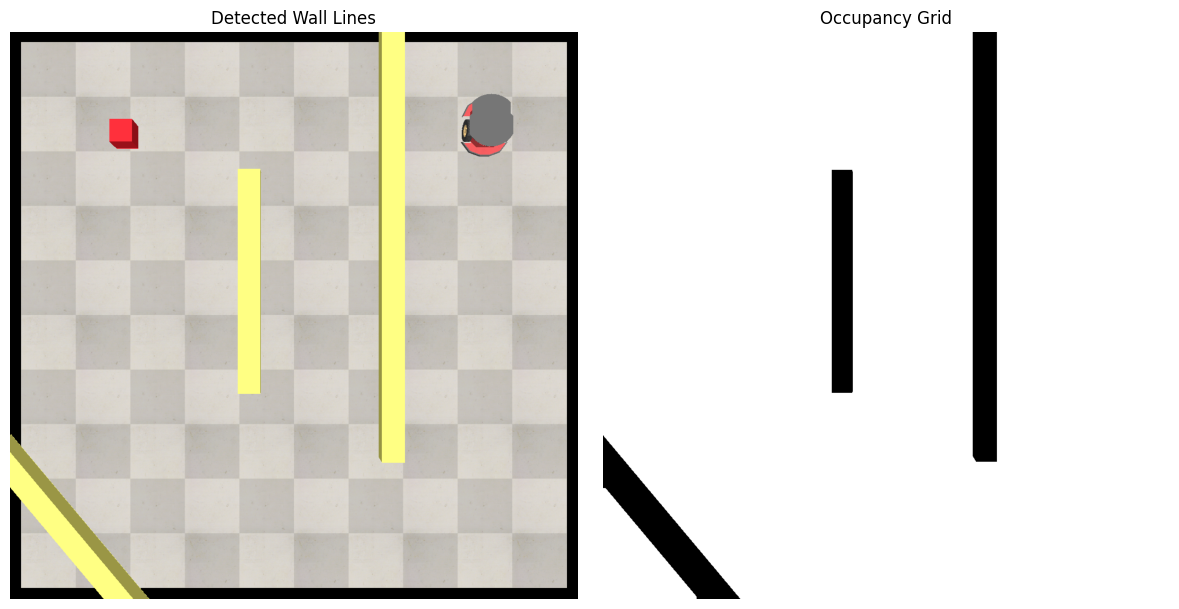

In [12]:
sim.startSimulation()
for _ in range(1):
    client.step()
    time.sleep(0.5)
    client.step()

    # 1. Grab image & segment
    frame, _, _ = camera.getFrame()
    plt.imshow(frame)
    mask = segment_yellow_borders(frame)

    grid = (mask == 0).astype(np.uint8)  # 1 = free, 0 = obstacle


    print("Grid Shape:", grid.shape)
    print("Amount of Free Cells:", np.sum(grid))
    print("Amount of Occupied Cells:", np.sum(grid == 0))

    # Plot the frame with blue wall lines
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(frame)
    plt.title("Detected Wall Lines")
    plt.axis("off")

    # Plot the binary grid (1 = free, 0 = obstacle)
    plt.subplot(1, 2, 2)
    plt.imshow(grid, cmap='gray')
    plt.title("Occupancy Grid")
    plt.axis("off")

    plt.tight_layout()
    plt.show()


sim.stopSimulation()


Robot Position: [-1.7249524907869136, -1.7002754916200316, 0.13870204122500857]
Goal Position: [1.5249999959680562, -1.624999120853368, 0.1887900894056242]


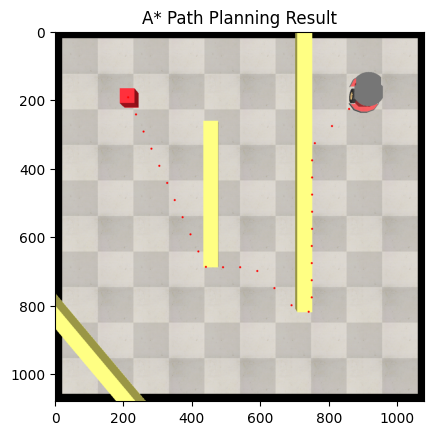

Robot Position: [-1.725091970557069, -1.7101978672584635, 0.13870663189700258]
Goal Position: [1.524999988167154, -1.6249991115616904, 0.18879008940614112]


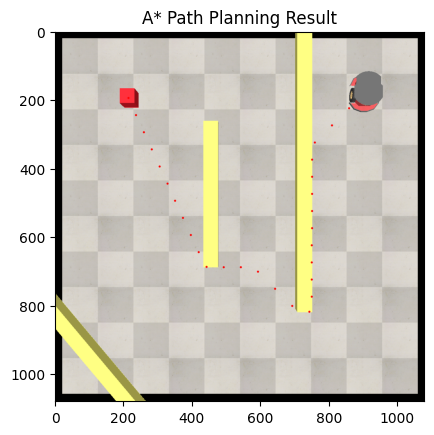

In [ ]:
sim.startSimulation()
for _ in range(2):
    client.step()
    time.sleep(0.5)
    client.step()
    cv2_frame, resx, resy = camera.getFrame()

    # 1. Get Robot and Goal Positions (in world coordinates)
    robot_pos = sim.getObjectPosition(robot_gps_handle, -1)
    print('Robot Position:', robot_pos)
    robot_u, robot_v = world_to_pixel_coordinates(camera, robot_pos[0], robot_pos[1], robot_pos[2])

    goal_pos = sim.getObjectPosition(goal_gps_handle, -1)
    print('Goal Position:', goal_pos)
    goal_u, goal_v = world_to_pixel_coordinates(camera, goal_pos[0], goal_pos[1], goal_pos[2])  # pixel coordinates

    # 2. Segment walls from image
    mask = segment_yellow_borders(cv2_frame)

    # 4. Create occupancy grid (1 = free, 0 = obstacle)
    grid = (mask == 0).astype(np.uint8)  # 1 = free, 0 = obstacle

    # Optional: make walls thicker to account for robot size
    kernel = np.ones((3,3), np.uint8)

    # 5. Run A* on the grid
    x_start, y_start = int(robot_u), int(robot_v)
    x_goal,  y_goal  = int(goal_u),  int(goal_v)

    start = (y_start, x_start)  # (row, col)
    goal  = (y_goal, x_goal)

    path = astar(grid, start, goal)

    if path:
        path = path[::50]  # reduce path resolution
    
    # Remove the first point if it's the robot's position
    if path and path[0] == start:
        path = path[1:]

    # 6. Visualize result
    if path:
        for (y, x) in path:
            cv2.circle(cv2_frame, (x, y), 5, (255, 0, 0), -1)
        plt.imshow(cv2_frame)
        plt.title('A* Path Planning Result')
        plt.show()
    else:
        print("No path found.")

sim.stopSimulation()

# Motion Planning

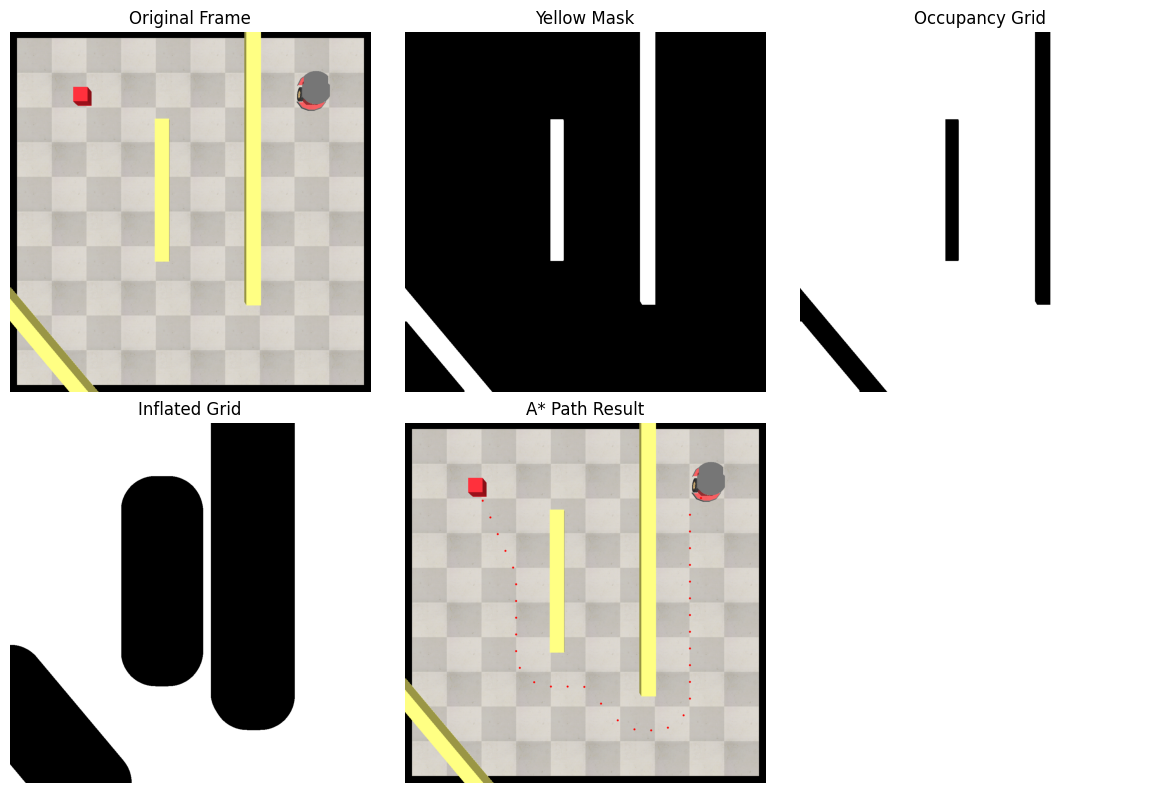

In [24]:
sim.startSimulation()
for _ in range(1):
    client.step()
    time.sleep(0.5)
    client.step()

    # 1. Grab frame and compute everything
    cv2_frame, resx, resy = camera.getFrame()
    robot_pos = sim.getObjectPosition(robot_gps_handle, -1)
    robot_u, robot_v = world_to_pixel_coordinates(camera, *robot_pos)
    goal_pos = sim.getObjectPosition(goal_gps_handle, -1)
    goal_u, goal_v = world_to_pixel_coordinates(camera, *goal_pos)

    mask = segment_yellow_borders(cv2_frame)
    grid = (mask == 0).astype(np.uint8)

    # inflate obstacles
    K, W, H = camera.getIntrinsics()
    fx, fy = K[0,0], K[1,1]
    rx = int((0.2/2)*fx); ry = int((0.2/2)*fy)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2*rx,2*ry))
    inflated = cv2.dilate(1-grid, kernel)
    inflated = 1-inflated

    path = astar(inflated, (int(robot_v),int(robot_u)), (int(goal_v),int(goal_u)))
    if path:
        path = path[::50]
        if path[0]==(int(robot_v),int(robot_u)): path=path[1:]
        frame_path = cv2_frame.copy()
        for (y,x) in path:
            cv2.circle(frame_path, (x,y), 3, (255,0,0), -1)
    else:
        frame_path = cv2_frame.copy()

    # 2. Plot everything with subplots
    plt.figure(figsize=(12, 8))

    plt.subplot(2, 3, 1)
    plt.imshow(cv2_frame)
    plt.title('Original Frame'); plt.axis('off')

    plt.subplot(2, 3, 2)
    plt.imshow(mask, cmap='gray')
    plt.title('Yellow Mask'); plt.axis('off')

    plt.subplot(2, 3, 3)
    plt.imshow(grid, cmap='gray')
    plt.title('Occupancy Grid'); plt.axis('off')

    plt.subplot(2, 3, 4)
    plt.imshow(inflated, cmap='gray')
    plt.title('Inflated Grid'); plt.axis('off')

    plt.subplot(2, 3, 5)
    plt.imshow(frame_path)
    plt.title('A* Path Result'); plt.axis('off')

    plt.tight_layout()
    plt.show()

sim.stopSimulation()


# Following the Proposed Route

Path in World Coordinates:


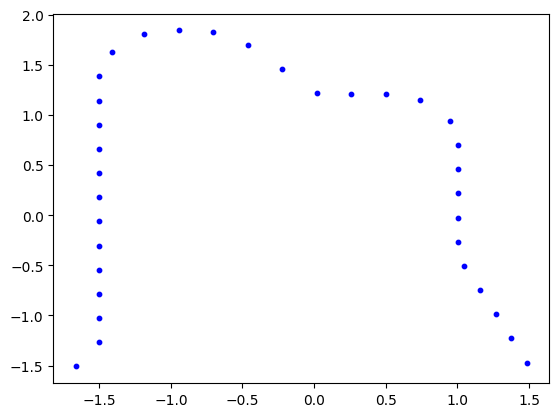

In [25]:
path_world = [pixel_to_world_coordinates(camera, (x, y), depth_on_floor(camera, x, y)) for (y, x) in path]
print("Path in World Coordinates:")
path_world = np.array(path_world)
plt.scatter(path_world[:, 0], path_world[:, 1], color='blue', s=10, label='A* Path in World')
plt.show()

In [16]:
import time
from math import atan2, sqrt, pi

class PID:
    def __init__(self, Kp, Ki, Kd):
        self.Kp = Kp
        self.Ki = Ki
        self.Kd = Kd
        self.integral = 0
        self.prev_error = 0

    def update(self, error, dt):
        self.integral += error * dt
        derivative = (error - self.prev_error) / dt if dt > 0 else 0
        self.prev_error = error
        return self.Kp * error + self.Ki * self.integral + self.Kd * derivative

def distance_2d(p1, p2):
    return sqrt((p1[0]-p2[0])**2 + (p1[1]-p2[1])**2)

def normalize_angle(angle):
    return (angle + pi) % (2 * pi) - pi

# PID controller for heading
pid = PID(Kp=2.5, Ki=0.0, Kd=0.4)

left_motor = sim.getObject('/PioneerP3DX/leftMotor')
right_motor = sim.getObject('/PioneerP3DX/rightMotor')

# Tuning params
linear_speed = 0.7  # m/s
goal_tolerance = 0.2  # m
dt = 0.05  # control step

sim.startSimulation()
time.sleep(0.5)

for _ in range(1000):
    client.step()
    time.sleep(dt)

    # Get robot pose
    robot_pos = sim.getObjectPosition(robot_handle, -1)
    robot_ori = sim.getObjectOrientation(robot_handle, -1)
    robot_theta = robot_ori[2]  # yaw

    # Find nearest point in path_world
    dists = [distance_2d(robot_pos, p) for p in path_world]
    nearest_idx = int(np.argmin(dists))

    # Stop if close to goal
    if nearest_idx >= len(path_world) - 2:
        print("Goal reached")
        sim.setJointTargetVelocity(left_motor, 0)
        sim.setJointTargetVelocity(right_motor, 0)
        break

    target = path_world[nearest_idx + 1]
    dx = target[0] - robot_pos[0]
    dy = target[1] - robot_pos[1]

    # Compute desired heading
    desired_theta = atan2(dy, dx)
    heading_error = normalize_angle(desired_theta - robot_theta)

    # PID for angular velocity
    omega = pid.update(heading_error, dt)

    # Constant forward speed if aligned
    distance = distance_2d(robot_pos, target)
    v = linear_speed if abs(heading_error) < pi / 4 else 0.0

    # Convert to wheel velocities
    left_motor_rel = sim.getObjectPosition(left_motor, robot_handle)
    right_motor_rel = sim.getObjectPosition(right_motor, robot_handle)

    L = np.linalg.norm(np.array(left_motor_rel[:2]) - np.array(right_motor_rel[:2]))
    vl = v - omega * L / 2
    vr = v + omega * L / 2

    sim.setJointTargetVelocity(left_motor, vl)
    sim.setJointTargetVelocity(right_motor, vr)

sim.stopSimulation()

Goal reached


In [17]:
#client.setStepping(True)
#sim.startSimulation()


# time.sleep(0.5)  # esperar medio segundo antes de la primera lectura